In [1]:
# Ejemplo de regresión lineal simple y  múltiple en propiedades inmobiliarias de Argentina en 2021. Fuente Properati
#El siguiente código se propone la aplicación de dos enfoques de Machine learning (regresión lineal simple y múltiple) sobre un data set de información inmobiliaria.
# Estaremos usando Python como modo de crear algoritmos que aprendan e infieran reglas de negocios aplicadas a partir de información etiquetada. 
# Podremos responder preguntas de importancia tales cómo: qué tipo de propiedades son las más valoradas en el mercado? el valor de la propiedad aumenta al construír una habitación? qué impacto tiene la superficie del inmueble sobre su precio?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk

# Indicamos que los tipos de datos float se muestren con 2 decimales 
pd.options.display.float_format = '{:.2f}'.format



In [2]:
#Importación del archivo en formato .csv. 
# El mismo se encuentra suministrado por Properati, una plataforma digital de bienes raíces que permite a los usuarios buscar inmuebles en venta y alquiler.
# Es una startup argentina con presencia en varios países de América del Sur, como Argentina, Colombia, Ecuador, Perú y Uruguay. Properati funciona como un buscador de anuncios clasificados para facilitar la búsqueda de propiedades, conectando a compradores y vendedores de manera eficiente.
import pandas as pd

df = pd.read_csv(
    r"C:\Users\lucas\Downloads\properati_argentina_2021.csv"
)



In [3]:
#Primera visualización del dataframe
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.96,-68.11,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.00,NaN,NaN,206.00,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.89,-56.09,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.00,3.00,193.00,193.00,390000.00,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.49,-58.26,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.00,45.00,47000.00,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.90,-54.81,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.00,NaN,180.00,400000.00,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.95,-68.04,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.00,2.00,NaN,98.00,102000.00,USD,PH - Villa Farrell


In [4]:
# Convertir la columna 'created_on' a datetime en caso de querer realizar operaciones de time intelligence
df['created_on'] = pd.to_datetime(df['created_on'])


In [5]:
#Observamos el rango de fechas contenido en nuestro data set.
fecha_min = df['created_on'].min()
fecha_max = df['created_on'].max()

print("Fecha mínima:", fecha_min)
print("Fecha máxima:", fecha_max)


Fecha mínima: 2021-01-01 00:00:00
Fecha máxima: 2021-12-31 00:00:00


In [6]:
# Definimos la semilla ya que trabajaremos en un futuro con procesos aleatorizados a la hora de devidir nuestros conjuntos de datos en subconjuntos de prueba y entrenamiento.
SEMILLA = 1992


In [7]:
#No trabajaremos con el dataset entero sino que haremos un filtro según tipo de propiedad, ubicación, tipo de operación inmobiliaria y divisa.
df2 = df[
    (df["property_type"].isin(["Casa", "Departamento", "PH"])) &
    (df["place_l2"] == "Capital Federal") &
    (df["operation"] == "Venta") &
    (df["property_currency"] == "USD")
].copy()


In [8]:
# Los valores faltantes o na pueden alterar nuestros cálculos por lo que es conveniente siempre hacer un traramiento de los valores faltantes y de las inconsistencias de un Data Frame.
# Comenzamos por generar una tabla que nos indica la cantidad de valores faltantes por columna.
na_por_columna = (
    df2.isna()
       .sum()
       .reset_index()
       .rename(columns={
           "index": "columna",
           0: "cantidad_na"
       })
)

na_por_columna


,columna,cantidad_na
0,id,0
1,start_date,0
2,end_date,0
3,created_on,0
4,latitud,3730
5,longitud,3730
6,place_l2,0
7,place_l3,417
8,place_l4,90606
9,place_l5,94249


In [9]:
# Como las variables de cantidad de cuartos, dormitorios, superficie total y superficie cubierta son centrales en lo que va a ser nuestro análisis, optamos por borrar todos los registros con datos faltantes en alguna de estas columnas.
# El dataset resultante se llama df2 y es el que usaremos en todos los análisis que siguen
df2 = df2.dropna(
    subset=[
        "property_rooms",
        "property_bedrooms",
        "property_surface_total",
        "property_surface_covered"
    ]
).copy()


In [10]:
#Comparamos la cantidad de datos en el dataset original y el filtrado. Es esperable que df2 tenga menos registros que el df original al no tener valores na en las columnas especificadas.
print(df.shape)
print(df2.shape)

(460154, 20)
(75888, 20)


In [11]:
#Además de lo anterior, hay ciertas inconsistencias que alteran los datos. Se eliminaron los registros donde la superficie total era menos a la cubierta. Se eliminaron todos los registros de superficie cubierta igual a 1.
#Se eliminaron registros donde la cantidad de dormitorios era mayor a la de las habitaciones y en donde los dormitorios eran menores a 1.
# Estas alteraciones parecen deberse a errores en Data Entry y responden a cuestiones que son inconcebibles en un plano real. Es por eso que se consideran inconcistencias a ser tratadas en el proceso de Transformación de datos.
df2.drop(df2.query('property_surface_total < property_surface_covered').index, inplace=True)
df2.drop(df2.query('property_surface_covered == 1').index , inplace=True)
df2.drop(df2[df2['property_bedrooms'] > df2['property_rooms']].index, inplace=True)
df2.drop(df2[df2['property_bedrooms']< 1].index, inplace=True)

df2.shape

(75582, 20)

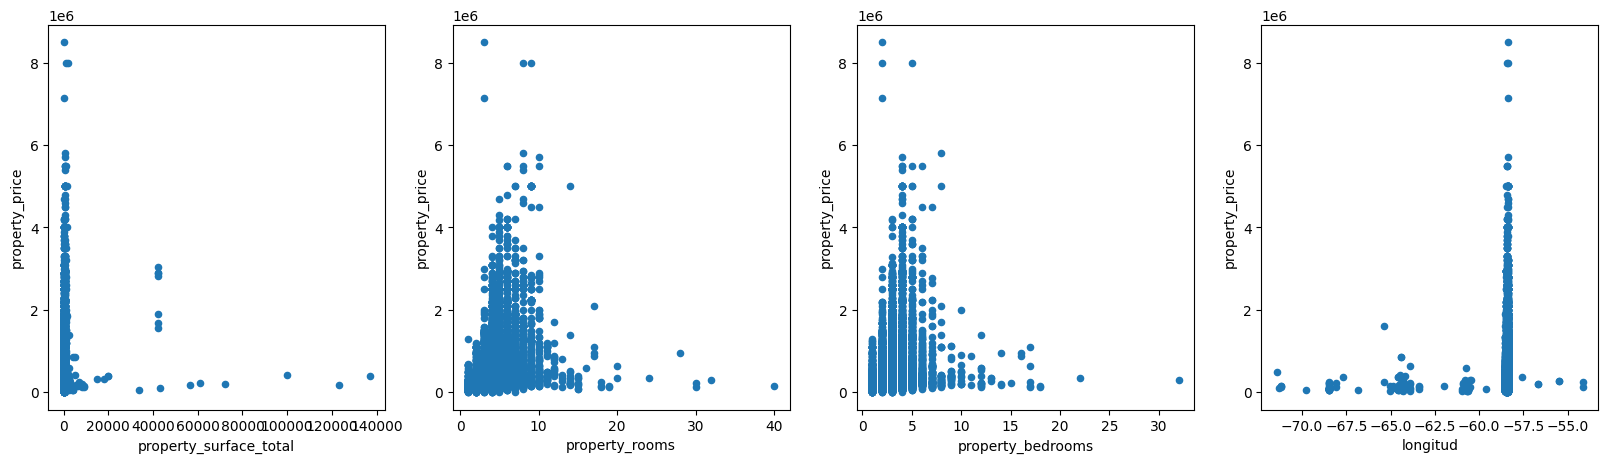

In [12]:
# Graficamos algunas de las relaciones entre las variables del data set el precio. Es importante señalar que, en estos ejemplos de Machine Learning el precio va a ser la variable a explicar o dependiente 
# Los gráficos de tipo Scatter Plot muestran reflerjar algun tipo de relación sea directa o indirecta entre variables.
#Estos gráficos nos son útiles también para observar la presencia de valores atípicos o outliers como por ejemplo la precencia de inmuebles con 40 baños o de valores económicos muy altos por encima del resto.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
df2.plot.scatter(x='property_surface_total', y='property_price', ax=ax1)
df2.plot.scatter(x='property_rooms', y='property_price', ax=ax2)
df2.plot.scatter(x='property_bedrooms', y='property_price', ax=ax3)
df2.plot.scatter(x='longitud', y='property_price', ax=ax4);

In [13]:
# Pensando una regesión lineal simple podríamos querer ver la relación que existe entre la variable de property_rooms y el precio
# Para realizarn un limpieza preliminar de los features que van a alimentar al algoritmo de la regresión haremos un tratamiento de los valores extremos.


In [14]:
# El siguiente código crea una tabla para observar cuantas propiedades tienen datos extremos en la variable property_rooms.
# Es de nuestro entendimiento que, es muy probable que los valores extremos existan por mal data_entry. Es decir, que de restringir los registros a solo una cifra (del 0 al 9) podríamos tener un acercamiento menos sesgado a la situación real.

df2_rooms_freq = (
    df2['property_rooms']
    .value_counts()
    .reset_index()
    .rename(columns={
        'index': 'property_rooms',
        'property_rooms': 'frecuencia'
    })
)
df2_rooms_freq

,frecuencia,count
0,3.00,24265
1,2.00,23860
2,4.00,14827
3,1.00,5166
4,5.00,4543
5,6.00,1641
6,7.00,655
7,8.00,316
8,9.00,135
9,10.00,85


In [15]:
#Restringimos el df2 como indicamos arriba
df2 = df2[df2['property_rooms'].between(1, 9)]


<Axes: xlabel='property_rooms', ylabel='property_price'>

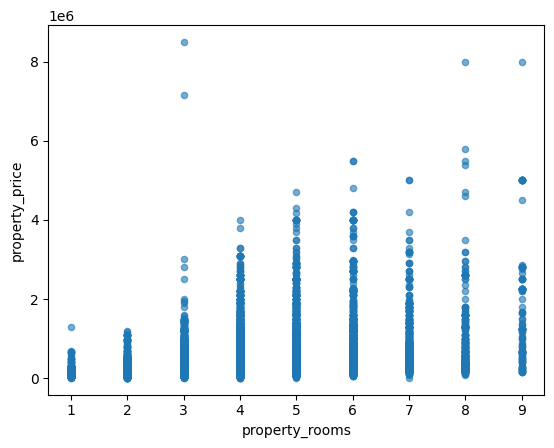

In [16]:
df2.plot.scatter(
    x='property_rooms',
    y='property_price',
    alpha=0.6
)


In [17]:
from sklearn.linear_model import LinearRegression
# Importamos la libería que usaremos para la regresión lineal simple.

model = LinearRegression(fit_intercept=True)
# Se instancia la clase adentro de la variable model
# Este código permite ajustar un intercepto mediante fit_intercept=True y hace que no necesariamete tenga que pasar por el origen de coordenadas
# Como segundo paso definimos del df que variables vamos a estar usando como x (features) e y (Target) para entrenar al modelo.
x=df2.loc[:, ['property_rooms']] 
# Tambien hubiese sido posible la versión fancy indexing x=[['property_rooms']]de doble corchete
#Devuelve un objeto bi dimensional o data frame sumamente necesario porque es lo que el modelo espera para la variable feature
y=df2["property_price"] 
#y es una Serie de Pandas, vector que se corresponde 1 a 1 con la longitud del n de x (bi dimensional)

In [18]:
#Entrenamos nuestro modelo para realizar una regresión lineal y sacamos el Beta 0 o intercepto y el Beta 1 o coeficiente
model.fit(x,y)
print(model.coef_)
print(model.intercept_)

[125897.05709345]
-142101.5957876507


In [19]:
# La interpretación del intercepto no tiene sentido comercial ya que sería el valor esperado para un inmueble sin habitaciones
# Sin embargo, el coeficiente nos dice  por cada ambiente adicional, el precio de la propiedad aumenta en promedio 51,924.35 unidades monetarias. Esto tiene mucha importancia de negocio.


In [20]:
#Regresión lineal múltiple.
# Además de lo anterior podríamos querer evaluar el impacto en el precio de un inmueble de la variación de más de uno de sus atributos en simultáneo y su potencial interacción.
# Esto se aborda desde algoritmos de regresión lineal múltiple como el que explayamos aquí debajo.
# Cabe recordar que nuestra variable a predecir seguirá siendo property_price, pero ahora contamos con múltiples variables predictoras Superficie Totañ, superficie cubierta de la propiedad en metros cuadrados, cantidad de ambientes/cuartos y Tipo de propiedad.



In [21]:
# Separamos al dataset en X (variables predictoras) e y (variable a predecir)
#Esto es muy importante ya que en el futuro querremos evaluar cuan fidedignamente se adapta nuestro algoritmo a valores de la realidad.
# Se separa entocnes nuestro dataset en un grupo de datos de entrenamiento, los que estarán disponibles en un primer momento para el algoritmo y un conjunto de datos de entrenamiento con los cuales se verá la adaptación del algoritmo a posibles escenarios reales.
X = df2[['property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_type']]
y = df2['property_price']

In [22]:
from sklearn.model_selection import train_test_split
# Realizamos el split de X e y en los sets de entrenamiento (train) y test especificando el tamaño del mismo (20 porciento) y la semilla para que el proceso de aleatorización sea el mismo. Usamos la función train_test_split de sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEMILLA)

In [23]:
print(f"El dataset de entrenamiento cuenta con {len(X_train)} observaciones")
print(f"El dataset de evaluación cuenta con {len(X_test)} observaciones")

El dataset de entrenamiento cuenta con 60326 observaciones
El dataset de evaluación cuenta con 15082 observaciones


In [24]:
# Definimos las variables exogenas (predictores) y las asignamor a una nueva variable. Ambas son variables cuantitativas (cointnua en caso de la superficie y discreta en cuanto a las habitaciones). Esta distinción es importante ya que el algoritmo cambia en su interpretación y código si se lo aplica a variables categóricas e
variables_exogenas = ['property_surface_total',  'property_bedrooms']

In [25]:
# Construimos la matriz de X asignando el data frame resultante del filtro de xtrain (bidimensional) y su asignación a una nueva variable.
#Los algoritmos de regresion lineal necesitan un dataframe para las variables predictoras y una Serie de Pandas para la variable y a predecir.
X_train_modelo_sup_bed = X_train[variables_exogenas]
X_train_modelo_sup_bed.head()

,property_surface_total,property_bedrooms
199169,113.00,4.00
69614,300.00,3.00
28071,54.00,2.00
282602,60.00,1.00
137044,52.00,1.00


In [26]:
# Definimos una instancia del modelo lineal con scikit learn tal como hicimos ya anteriormente
modelo_lineal_sup_bed = LinearRegression(fit_intercept=True)

In [27]:
# Realizamos el proceso de estimación usando el property_price incluído ya en la variable y_train
modelo_lineal_sup_bed.fit(X_train_modelo_sup_bed, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [28]:
# Accedemos a los coeficientes estimados
modelo_lineal_sup_bed.coef_

array([2.17771491e+01, 1.40420701e+05])

In [29]:
# Accedemos al intercepto
modelo_lineal_sup_bed.intercept_

np.float64(-44904.83745890396)

In [30]:
# Creamos variables para guardar los coeficientes estimados
coeficientes = modelo_lineal_sup_bed.coef_
intercepto = modelo_lineal_sup_bed.intercept_
beta_1, beta_2 = coeficientes[0], coeficientes[1] 

In [31]:
print(f"El intercepto es {intercepto:.2f}")
print(f"El coeficiente estimado para Beta 1 es {beta_1:.2f}")
print(f"El coeficiente estimado para Beta 2 es {beta_2:.2f}")

El intercepto es -44904.84
El coeficiente estimado para Beta 1 es 21.78
El coeficiente estimado para Beta 2 es 140420.70


In [32]:
#La interpretación de esta regresión lineal múltiple sería la siguiente:
# El intercepto nuevamente no tendría sentido comercial: sería el precio de una propiedad sin superficie total ni habitaciones
# el B1 de 1417,11 quiere decir que el precio de la propiedad aumentaría en 1417,11 dólares por cada metro más de superficie total cubierta por el inmueble dado el mismo número de cuartos.
# El b2 de 11641.73 dice que la propiedad aumenta en 11641,73 dólares por cada habitacón, si se mantiene igual el número de superficie total del inmueble.
# 

C:\Users\lucas\AppData\Local\Temp\ipykernel_30696\1185903515.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


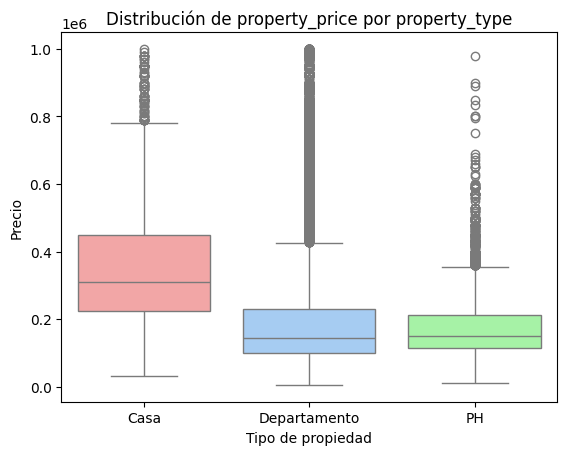

In [33]:
# Incluir una variable categórica como "property_type" (con 3 valores distintos posibles) a nuestra regresión lineal múltiple.
#Este tipo de problemas es muy común en negocios pero trae ciertas consideraciones ante la implementación del código y la interpretación de los resultados.
# En resumen, hay que estar atentos de no caer en lo que se conoce como "Trampa Dummy" Y operacionalizar las variables categóricas siempre con un n-1 de categorías en nuestro modelo. Esto evita el problema de la Multicolinealidad perfecta.
#Para facilitar la comparación acotamos el rango a propiedades de menos de 1 millón de USD.
#Comenzamos con gráficos de tipo boxplot para estudiar la distribución de los precios según el tipo de propiedades. Llama la atención que el valor de la media de las casas es mayor al de los PH y departamentos. También las casas son las que menor cantidad de outliers de los 3 tipos de propiedades.
#Esto es indicativo de que puede ser importante considerar el impacto que tiene el tipo de propiedad en la variable del precio.
import seaborn as sns
import matplotlib.pyplot as plt

colores = ['#FF9999', '#99CCFF', '#99FF99']

# Crear boxplot
sns.boxplot(
    x="property_type",
    y="property_price",
    data=df2.query("property_price <= 1000000"),
    palette=colores
)

plt.title("Distribución de property_price por property_type")
plt.ylabel("Precio")
plt.xlabel("Tipo de propiedad")
plt.show()




In [34]:
#Estudiaremos la implemantación de un modelo de regresión lineal que contemple tanto la superficie total del inmueble como su tipo de propiedad en el impacto que tienen sobre el precio.
#Es necesario tansformar las categorías de nombres a números (secuencias de 1 y 0 ) para poder operacionalizar el modelo.

In [35]:
#Para evitar la trampa dummy, tomaremos la función one_hot_encoder, que reducirá a 2 las 3 categorías de property_type. Drop no genera una variable para ph, quedará contenida en el intercepto para evitar la trampa dummy.
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(categories=[['PH', 'Casa', 'Departamento']], drop='first')
one_hot_encoder.fit(X_train[['property_type']])
#Realizamos el entrenamiento del modelo con los datos de entrenamiento.

,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute... versionadded:: 0.20","[['PH', 'Casa', ...]]"
,"drop drop: {'first', 'if_binary'} or an array-like of shape (n_features,), default=NoneSpecifies a methodology to use to drop one of the categories perfeature. This is useful in situations where perfectly collinearfeatures cause problems, such as when feeding the resulting datainto an unregularized linear regression model.However, dropping one category breaks the symmetry of the originalrepresentation and can therefore induce a bias in downstream models,for instance for penalized linear classification or regression models.- None : retain all features (the default).- 'first' : drop the first category in each feature. If only one category is present, the feature will be dropped entirely.- 'if_binary' : drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.- array : ``drop[i]`` is the category in feature ``X[:, i]`` that should be dropped.When `max_categories` or `min_frequency` is configured to groupinfrequent categories, the dropping behavior is handled after thegrouping... versionadded:: 0.21 The parameter `drop` was added in 0.21... versionchanged:: 0.23 The option `drop='if_binary'` was added in 0.23... versionchanged:: 1.1 Support for dropping infrequent categories.",'first'
,"sparse_output sparse_output: bool, default=TrueWhen ``True``, it returns a :class:`scipy.sparse.csr_matrix`,i.e. a sparse matrix in ""Compressed Sparse Row"" (CSR) format... versionadded:: 1.2 `sparse` was renamed to `sparse_output`",True
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'ignore', 'infrequent_if_exist', 'warn'}, default='error'Specifies the way unknown categories are handled during :meth:`transform`.- 'error' : Raise an error if an unknown category is present during transform.- 'ignore' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.- 'infrequent_if_exist' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. The infrequent category will be mapped to the last position in the encoding. During inverse transform, an unknown category will be mapped to the category denoted `'infrequent'` if it exists. If the `'infrequent'` category does not exist, then :meth:`transform` and :meth:`inverse_transform` will handle an unknown category as with `handle_unknown='ignore'`. Infrequent categories exist based on `min_frequency` and `max_categories`. Read more in the :ref:`User Guide `.- 'warn' : When an unknown category is encountered during transform a warning is issued, and the encoding then proceeds as described for `handle_unknown=""infrequent_if_exist""`... versionchanged:: 1.1 `'infrequent_if_exist'` was added to automatically handle unknown categories and infrequent categories... versionadded:: 1.6 The option `""warn""` was added in 1.6.",'error'
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.1 Read more in the :ref:`User Guide `

In [36]:
#Podemos acceder a los atributos de la variable creada. Las categorías son exactamente como queríamos.
one_hot_encoder.categories


[['PH', 'Casa', 'Departamento']]

In [37]:
matriz_dummies = one_hot_encoder.transform(X_train[['property_type']]).toarray()
#Este paso crea una matriz de dos dimensiones


In [38]:
nombres_dummies = one_hot_encoder.get_feature_names_out(['property_type'])
nombres_dummies
#Devuelve un array de strings con los nombres de las columnas generadas por el encoder

array(['property_type_Casa', 'property_type_Departamento'], dtype=object)

In [39]:
#Generamos finalmente un dataframe con la matriz y el nombre y dejamos el índice de los datos que transformamos.
df_dummies = pd.DataFrame(matriz_dummies, columns=nombres_dummies, index=X_train.index)
df_dummies.head()

,property_type_Casa,property_type_Departamento
199169,0.00,1.00
69614,0.00,1.00
28071,0.00,1.00
282602,0.00,1.00
137044,0.00,1.00


In [40]:
# Agregamos la información a nuestra matriz de variables predictoras, se agrega la información del df creado al data frame de las variables explicativas que contiene todas las variables exógenas que podemos ir seleccionando.
X_train = X_train.join(df_dummies)
X_train.head()

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_type,property_type_Casa,property_type_Departamento
199169,5.00,4.00,113.00,97.00,Departamento,0.00,1.00
69614,5.00,3.00,300.00,300.00,Departamento,0.00,1.00
28071,3.00,2.00,54.00,47.00,Departamento,0.00,1.00
282602,2.00,1.00,60.00,50.00,Departamento,0.00,1.00
137044,2.00,1.00,52.00,47.00,Departamento,0.00,1.00


In [41]:

#Creamos una función que facilita la devolución de los coeficientes de los cálculos de Regresión.
def obtener_coeficientes(modelo, lista_variables):
  '''Crea un dataframe con los coeficientes estimados de un modelo'''
  # Creo la lista de nombres de variables
  lista_variables = ['intercepto'] + lista_variables
  # Intercepto
  intercepto = modelo.intercept_
  # Lista coeficientes excepto el intercepto
  coeficientes = list(modelo.coef_)
  # Lista completa coeficientes
  lista_coeficientes = [intercepto] + coeficientes
  return pd.DataFrame({"variable": lista_variables, "coeficiente": lista_coeficientes})

In [42]:
# Definimos las variables exogenas (predictores)
variables_exogenas = ['property_surface_total', 'property_type_Casa', 'property_type_Departamento']

# Construimos la matriz de X
X_train_modelo_sup_propiedad = X_train[variables_exogenas]

# Definimos una instancia del modelo lineal con scikit learn
modelo_lineal_sup_propiedad = LinearRegression(fit_intercept=True)

# Realizamos el proceso de estimación
modelo_lineal_sup_propiedad.fit(X_train_modelo_sup_propiedad, y_train)

coeficientes_modelo_sup_propiedad = obtener_coeficientes(modelo_lineal_sup_propiedad, variables_exogenas)
coeficientes_modelo_sup_propiedad

,variable,coeficiente
0,intercepto,169376.98
1,property_surface_total,33.33
2,property_type_Casa,227356.97
3,property_type_Departamento,62161.86


In [43]:
#Interpretación
#El valor esperado de un ph sin superficie es de 169376 dólares. Carece de interpretación comercial.
# B1 indica que el precio esperado de la propiedad aumenta en 33,33 dolares por cada metro independientemente del tipo de la propiedad
# B2 Indica que si la propiedad es una casa el precio es 227356.97 mayor a un PH dada la sup total
# B3 indica que si la propiedad es un depto el precio esperado ser{a 62161.86 mayor respecto a un PH dada la misma superficie.




In [44]:
# En los modelos de regresión también es necesario pensar si existe algún tipo de interacción entre las variables cualitativas y las cuantitativas
# Esto exige un planteamiento de otro modelo de interacción y la creación de nuevas variables para calcular El Beta de interacción entre las variables
# Creamos las dos variables de interacción
X_train['interaccion_sup_casa'] = X_train['property_type_Casa'] * X_train['property_surface_total']
X_train['interaccion_sup_depto'] = X_train['property_type_Departamento'] * X_train['property_surface_total']


In [45]:
# Definimos las variables exogenas (predictores)
variables_exogenas = ['property_surface_total', 'property_type_Casa', 'property_type_Departamento', 'interaccion_sup_casa', 'interaccion_sup_depto']

# Construimos la matriz de X
X_train_modelo_interaccion = X_train[variables_exogenas]

# Definimos una instancia del modelo lineal con scikit learn
modelo_lineal_interaccion = LinearRegression(fit_intercept=True)

# Realizamos el proceso de estimación
modelo_lineal_interaccion.fit(X_train_modelo_interaccion, y_train)

coeficientes_modelo_interaccion = obtener_coeficientes(modelo_lineal_interaccion, variables_exogenas)
coeficientes_modelo_interaccion

,variable,coeficiente
0,intercepto,173929.86
1,property_surface_total,2.20
2,property_type_Casa,37071.71
3,property_type_Departamento,55884.62
4,interaccion_sup_casa,706.42
5,interaccion_sup_depto,49.26


In [46]:
"""
Interpretación de los coeficientes del modelo:

β0 = 68563
El precio esperado de un PH con superficie total igual a 0 es de 68.563 dólares.

β1 = 1058
Para un PH, el precio esperado aumenta en 1.058 dólares cuando la superficie total aumenta en 1 m2.
Este coeficiente corresponde a la categoría basal (PH).

β2 = -86032
Si la propiedad es una casa, el precio esperado es 86.032 dólares menor que el de un PH,
manteniendo constante la superficie total.

β3 = -166791
Si la propiedad es un departamento, el precio esperado es 166.791 dólares menor que el de un PH,
manteniendo constante la superficie total.

β4 = 729
Para una casa, el efecto de la superficie total sobre el precio aumenta en 729 dólares adicionales
respecto a un PH por cada 1 m2 extra.
Por lo tanto, para una casa el precio esperado aumenta en:
1058 + 729 = 1787 dólares por cada 1 m2.

β5 = 3228
Para un departamento, el efecto de la superficie total sobre el precio aumenta en 3.228 dólares
adicionales respecto a un PH por cada 1 m2 extra.
Por lo tanto, para un departamento el precio esperado aumenta en:
1058 + 3228 = 4286 dólares por cada 1 m2.
"""


'\nInterpretación de los coeficientes del modelo:\n\nβ0 = 68563\nEl precio esperado de un PH con superficie total igual a 0 es de 68.563 dólares.\n\nβ1 = 1058\nPara un PH, el precio esperado aumenta en 1.058 dólares cuando la superficie total aumenta en 1 m2.\nEste coeficiente corresponde a la categoría basal (PH).\n\nβ2 = -86032\nSi la propiedad es una casa, el precio esperado es 86.032 dólares menor que el de un PH,\nmanteniendo constante la superficie total.\n\nβ3 = -166791\nSi la propiedad es un departamento, el precio esperado es 166.791 dólares menor que el de un PH,\nmanteniendo constante la superficie total.\n\nβ4 = 729\nPara una casa, el efecto de la superficie total sobre el precio aumenta en 729 dólares adicionales\nrespecto a un PH por cada 1 m2 extra.\nPor lo tanto, para una casa el precio esperado aumenta en:\n1058 + 729 = 1787 dólares por cada 1 m2.\n\nβ5 = 3228\nPara un departamento, el efecto de la superficie total sobre el precio aumenta en 3.228 dólares\nadicionales 

In [47]:
#Evaluación de los modelos estadísticos.
# Cuanto predecimos parámetros a partir de estimadores estamos realizando saltos inferenciales que siempre están sujetos a posibilidades de error.
# Es por eso que necesitamos usar librerías como StatsModels que nos permitan realizar pruebas de significativida estadística para poder tomar las afirmaciones finales con respecto a los valores predichos.



In [48]:
X_train_modelo_sup_bed_stats = sm.add_constant(X_train_modelo_sup_bed)
X_train_modelo_sup_bed_stats.head()
# El intercepto se pasa al modelo como una constante 

,const,property_surface_total,property_bedrooms
199169,1.00,113.00,4.00
69614,1.00,300.00,3.00
28071,1.00,54.00,2.00
282602,1.00,60.00,1.00
137044,1.00,52.00,1.00


In [49]:
# Construimos el modelo
modelo_sup_bed_stats = sm.OLS(y_train, X_train_modelo_sup_bed_stats)
#OLS especifica la estimación mediante mínimos cuadrados ordinarios.

In [50]:
# Guardamos los resultados
resultados_sup_bed_stats = modelo_sup_bed_stats.fit()

In [51]:
# Accedemos a los coeficientes estimados
resultados_sup_bed_stats.params
# Nos fijamos que efectivamente con esta librería tengamos los mismos coeficientes que con SciKitLearn.

const                    -44904.84
property_surface_total       21.78
property_bedrooms        140420.70
dtype: float64

In [52]:
# Accedemos a los p valores de los tests de significancia individual hechos por varios test de Student de dos colas.
resultados_sup_bed_stats.pvalues
#Los p valores menores a 0.05 nos permiten afirmar que podemos rechazar la hipótesis nula con muy poco riesgo de caer en errores de tipo 1.


const                    0.00
property_surface_total   0.00
property_bedrooms        0.00
dtype: float64

In [53]:
# Test significatividad global como complementario a los individuales.
#Se estima mediante un test F.
resultados_sup_bed_stats.f_pvalue

np.float64(0.0)

In [54]:
# R cuadrado nos permite ver en porcentaje cuanto de la variacion de la y es explicada por nuestro modelo.
resultados_sup_bed_stats.rsquared

# R cuadrado ajustado
resultados_sup_bed_stats.rsquared_adj

np.float64(0.21394838648273895)

In [55]:
#Resumen tabulado de todos los indicadores estadísticos. 
print(resultados_sup_bed_stats.summary())

                            OLS Regression Results                            
Dep. Variable:         property_price   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     8211.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:26:59   Log-Likelihood:            -8.4007e+05
No. Observations:               60326   AIC:                         1.680e+06
Df Residuals:                   60323   BIC:                         1.680e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -4.4

In [56]:
#Haremos lo mismo con nuestro modelo de interacción
# En stats models se le agrega el intercepto 
X_train_interaccion_stats = sm.add_constant(X_train_modelo_interaccion)

#Construimos el modelo
modelo_interaccion_stats = sm.OLS(y_train, X_train_interaccion_stats)

# Estimamos los parámetros
resultados_interaccion = modelo_interaccion_stats.fit()

# Imprimimos el resumen
print(resultados_interaccion.summary())

                            OLS Regression Results                            
Dep. Variable:         property_price   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     486.4
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:26:59   Log-Likelihood:            -8.4614e+05
No. Observations:               60326   AIC:                         1.692e+06
Df Residuals:                   60320   BIC:                         1.692e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [57]:
# Hay ciertas métricas utilizadas para evaluar modelos de regresión pero que, a diferencia de las vistas anteriormente, tienen un enfoque específico de Machine Learning
# El Error Cuadrático Medio (MSE) es una de las más utilizadas.
# Todas ellas son implementaciones de la librería scikitlearn

# Importamos las métricas desde scikit-learn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#Para calcluar estas métricas, la librería realiza cálculos sobre los valores reales y predichos de y.

In [58]:
# Predecimos los valores de y con nuestro modelo
y_train_sup_bed = modelo_lineal_sup_bed.predict(X_train_modelo_sup_bed)
y_train_sup_bed

array([519238.78248848, 382890.40884677, 237112.52964202, ...,
       238027.16990449, 379710.94507725, 237983.61560628], shape=(60326,))

In [59]:
# Calculamos R cuadrado
r2_score(y_train, y_train_sup_bed)

# Calculamos MSE
mean_squared_error(y_train, y_train_sup_bed)

# Calculamos RMSE
np.sqrt(mean_squared_error(y_train, y_train_sup_bed))

# Calculamos MAE
mean_absolute_error(y_train, y_train_sup_bed)

123110.53591318867

In [60]:
def obtener_metricas_performance(y_verdadera, y_predicha, tipo_dataset):
    r2 = r2_score(y_verdadera, y_predicha)
    mse = mean_squared_error(y_verdadera, y_predicha)
    rmse = np.sqrt(mse) 
    mae = mean_absolute_error(y_verdadera, y_predicha)
    return pd.DataFrame({'metrica': ['R2', 'MSE', 'RMSE', 'MAE'],
                         'valor':[r2, mse, rmse, mae],
                         'tipo_dataset':tipo_dataset})

In [61]:
# Obtenemos nuestro dataframe de métricas de performance
performance_train_sup_bed = obtener_metricas_performance(y_train, y_train_sup_bed,'entrenamiento')
performance_train_sup_bed

,metrica,valor,tipo_dataset
0,R2,0.21,entrenamiento
1,MSE,72948010766.91,entrenamiento
2,RMSE,270088.89,entrenamiento
3,MAE,123110.54,entrenamiento


In [62]:
# Ahora observemos las métricas del modelo de interacción en entrenamiento
y_train_interaccion = modelo_lineal_interaccion.predict(X_train_modelo_interaccion)
performance_train_interaccion = obtener_metricas_performance(y_train, y_train_interaccion, 'entrenamiento')
performance_train_interaccion

,metrica,valor,tipo_dataset
0,R2,0.04,entrenamiento
1,MSE,89209099333.64,entrenamiento
2,RMSE,298678.92,entrenamiento
3,MAE,146599.84,entrenamiento


In [63]:
#Finalmente, podremos hacer uso de nuestro Dataset de evaluación para cálcular estas métricas.
# Creamos la matrix de X para el modelo de superficie y baños
X_test_sup_baños = X_test[['property_surface_total', 'property_bedrooms']]

In [64]:
# Predecimos los valores
y_test_sup_bed =  modelo_lineal_sup_bed.predict(X_test_sup_baños)
# Obtenemos nuestro dataframe de métricas de performance
performance_test_sup_bed =obtener_metricas_performance(y_test, y_test_sup_bed, 'evaluacion')
# Mostramos en conjunto las métricas para entrenamiento y evaluación
pd.concat([performance_train_sup_bed,performance_test_sup_bed])

,metrica,valor,tipo_dataset
0,R2,0.21,entrenamiento
1,MSE,72948010766.91,entrenamiento
2,RMSE,270088.89,entrenamiento
3,MAE,123110.54,entrenamiento
0,R2,0.21,evaluacion
1,MSE,69476018548.80,evaluacion
2,RMSE,263583.04,evaluacion
3,MAE,121217.50,evaluacion


In [65]:
# Generamos las variables dummies de la variable property type (notemos que tenemos 2 columnas!)
matriz_dummies_test = one_hot_encoder.transform(X_test[['property_type']]).toarray()
# Generamos el dataframe con las variables dummies con las matrices y columnas
df_dummies_test = pd.DataFrame(matriz_dummies_test, columns=nombres_dummies, index=X_test.index)
# Agregamos la información a nuestra matriz de variables predictoras
X_test = X_test.join(df_dummies_test)
# Creamos las dos variables de interacción
X_test['interaccion_sup_casa'] = X_test['property_type_Casa'] * X_test['property_surface_total']
X_test['interaccion_sup_depto'] = X_test['property_type_Departamento'] * X_test['property_surface_total']
# Vemos el dataframe
X_test.head()

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_type,property_type_Casa,property_type_Departamento,interaccion_sup_casa,interaccion_sup_depto
333823,4.00,3.00,304.00,199.00,Casa,1.00,0.00,304.00,0.00
313135,2.00,1.00,45.00,40.00,Departamento,0.00,1.00,0.00,45.00
172521,2.00,1.00,47.00,38.00,Departamento,0.00,1.00,0.00,47.00
42071,3.00,2.00,74.00,67.00,Departamento,0.00,1.00,0.00,74.00
147597,4.00,3.00,153.00,148.00,Departamento,0.00,1.00,0.00,153.00


In [66]:
# Generamos el dataset de predictoras
X_test_interaccion = X_test[['property_surface_total', 'property_type_Casa', 'property_type_Departamento', 'interaccion_sup_casa', 'interaccion_sup_depto']]

In [67]:
# Predecimos los valores
y_test_interaccion = modelo_lineal_interaccion.predict(X_test_interaccion)
# Obtenemos nuestro dataframe de métricas de performance
performance_test_interaccion = obtener_metricas_performance(y_test, y_test_interaccion, 'evaluacion')
# Mostramos en conjunto las métricas para entrenamiento y evaluación
pd.concat([performance_train_interaccion, performance_test_interaccion])

,metrica,valor,tipo_dataset
0,R2,0.04,entrenamiento
1,MSE,89209099333.64,entrenamiento
2,RMSE,298678.92,entrenamiento
3,MAE,146599.84,entrenamiento
0,R2,0.03,evaluacion
1,MSE,86188650151.08,evaluacion
2,RMSE,293579.04,evaluacion
3,MAE,145126.79,evaluacion


In [ ]:
#Para evaluar nuestro modelo podemos ver, gráficamente pero también con otras herramientas que se cumplan los supuestos de Gaus Markov que están en la base de las fórmulas de regresión 
#Podemos calcular un gráfico de dispersión con los valores predichos en el eje x y con los residuos en el y
# Calculamos los residuos para el modelo de superficie y baños
residuos_sup_bed = y_train - y_train_sup_bed

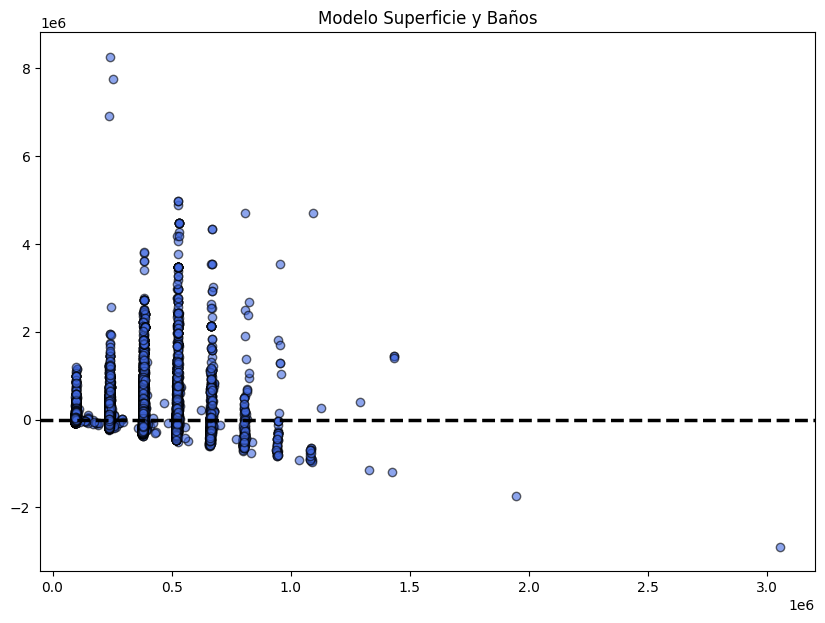

In [ ]:
# Realizamos el gráfico en donde podemos ver que no tenemos grandes sopechas para decir que el supuesto de homosedasticidad no se cumple (debido a la variación entre la distancia de los puntos del gráfico)
plt.figure(figsize=(10,7))
plt.scatter(x=y_train_sup_bed, y=residuos_sup_bed,
            alpha=0.6, c='royalblue', edgecolor='black')
plt.axhline(y=0, c='black', ls='--', linewidth=2.5)
plt.title("Modelo Superficie y Baños");